# **TF Serving**

## **1. 모델을 훈련하고 저장하기**

In [ ]:
from pathlib import Path
import tensorflow as tf

# minst 데이터를 저장하는 과정
mnist = tf.keras.datasets.mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = mnist
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

# 모델에 모든 전처리 층을 포함하는 것이 좋다.
tf.random.set_seed(42)
tf.keras.backend.clear_session()
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28], dtype=tf.uint8),
    tf.keras.layers.Rescaling(scale=1 / 255),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=1e-2),
              metrics=["accuracy"])
model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

model_name = "my_mnist_model"
model_version = "0001"
model_path = Path(model_name) / model_version
model.save(model_path, save_format="tf")

In [ ]:
sorted([str(path) for path in model_path.parent.glob("**/*")]) # 파일 트리를 살펴본다.

"""
['my_mnist_model/0001',   # 모델 버전
 'my_mnist_model/0001/assets', #vocab 파일과 같은 추가 모델
 'my_mnist_model/0001/fingerprint.pb', #모델의 식별자나 메타데이터와 같은 지문정보
 'my_mnist_model/0001/keras_metadata.pb', #keras 메타데이터(레이어 구성, 훈련 정보)
 'my_mnist_model/0001/saved_model.pb', #모델 구조, 계산 그래프 정의
 'my_mnist_model/0001/variables', # 훈련된 모델의 가중치, 파라미터
 'my_mnist_model/0001/variables/variables.data-00000-of-00001', #가중치,파라미터 조각
 'my_mnist_model/0001/variables/variables.index'] #가중치,파라미터 조각들의 인덱스
"""

In [ ]:
"""
SavedModel은 하나 이상의 메타그래프(계산 그래프에 입출력 이름, 타입과 같은 함수 시그니처 정의가 추가된 것)
을 포함 하는데, 훈련 연산을 포함하는 메타그래프는 'train'태그가, GPU연산을 포함해 예측 연산만 포함되는
메타그래프는 'serve' 또는 'gpu'와 같은 태그를 붙일 수 있다
save()메서드를 활용해 모델을 저장할때는 'serve'태그가 붙는다.
"""
!saved_model_cli show --dir '{model_path}' # serve tag

In [ ]:
"""
시그니처 정의(Signature Defs)와 구체적인 함수들(Concrete Functions)이 정리되어 있다.
시그니처 정의란 모델의 입출력 및 호출 방법(__call__메서드)를 명시하는 메타데이터를 의미한다.
즉 모델이 어떻게 구성되어 있고, 어떤 입출력을 기대하고 어떻게 호출되어야 하는지 등등이 쓰여 있는 것.
"""
!saved_model_cli show --dir '{model_path}' --all

## **2. 텐서플로 서빙을 설치하고 서버를 시작하기.**

```
**도커의 핵심 개념:**
컨테이너(Container): - 포장된 도시락
컨테이너는 애플리케이션과 그 필요한 모든 구성요소
(코드, 런타임, 시스템 도구, 시스템 라이브러리 등)를 포함하는 표준화된 유닛입니다.
가상 머신(VM)과 비슷하지만, 가벼우며 공유된 운영 체제(OS) 상에서 실행됩니다.

이미지(Image):  - 음식의 Recipe
도커 이미지는 컨테이너를 생성하는 데 사용되는 경량, 독립적이고 실행 가능한 소프트웨어 패키지입니다.
이미지는 애플리케이션과 모든 필요한 설정을 포함합니다.

도커 허브(Docker Hub): - Recipe 책 or 요리 웹사이트
도커 허브는 도커 이미지를 공유하고 관리하는 클라우드 기반의 서비스입니다.
사용자는 여기서 이미지를 업로드하고 다운로드할 수 있으며, 공식 이미지와 커뮤니티 이미지를 찾을 수 있습니다.

도커 파일(Dockerfile): - 상세한 Recipe 지침
도커 파일은 컨테이너를 만드는 방법을 설명하는 텍스트 문서입니다.
이 파일에는 컨테이너를 구성하는 데 필요한 지시어들이 포함됩니다.
```

In [2]:
# 우분투 apt 패키지 매니저(코랩 환경)를 사용해 텐서플로 서빙 설치하는 방법
# url, src, echo -> 저장소 설정 / curl -> 공개 키 추가 / apt, api -> 패키지 설치
url = "https://storage.googleapis.com/tensorflow-serving-apt"
src = "stable tensorflow-model-server tensorflow-model-server-universal"
!echo 'deb {url} {src}' > /etc/apt/sources.list.d/tensorflow-serving.list
!curl '{url}/tensorflow-serving.release.pub.gpg' | apt-key add -
!apt update -q && apt-get install -y tensorflow-model-server
%pip install -q -U tensorflow-serving-api==2.11.1

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0Warning: apt-key is deprecated. Manage keyring files in trusted.gpg.d instead (see apt-key(8)).
100  2943  100  2943    0     0  13314      0 --:--:-- --:--:-- --:--:-- 13377
OK
Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 https://storage.googleapis.com/tensorflow-serving-apt stable InRelease [3,026 B]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [631 kB]
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:7 https://storage.googleapis.com/tensorflow-serving-apt stable/tensorflow-model

In [3]:
# 코랩 환경에서 서버를 시작하는 방법. 1
import os

os.environ["MODEL_DIR"] = str(model_path.parent.absolute())

In [4]:
# 코랩 환경에서 서버를 시작하는 방법. 2
%%bash --bg
tensorflow_model_server \
    --port=8500 \
    --rest_api_port=8501 \
    --model_name=my_mnist_model \
    --model_base_path="${MODEL_DIR}" >my_server.log 2>&1

## **3. Rest API로 TF 서빙에 쿼리하기(예측 요청하기).**

In [5]:
# Rest API로 TF 서빙에 쿼리하기.
import json

X_new = X_test[:3]  # 분류할 새로운 숫자 이미지가 3개 있다고 가정합니다.
request_json = json.dumps({
    "signature_name": "serving_default",
    "instances": X_new.tolist(),
})

# request_json[:100] + "..." + request_json[-10:]

In [6]:
import requests

server_url = "http://localhost:8501/v1/models/my_mnist_model:predict"
response = requests.post(server_url, data=request_json)
response.raise_for_status()  # 오류가 있으면 예외 발생.
response = response.json()

In [8]:
import numpy as np

y_proba = np.array(response["predictions"])
y_proba.round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.99, 0.  , 0.  ],
       [0.  , 0.  , 0.97, 0.02, 0.  , 0.01, 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.98, 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]])

## **3-1. gRPC API로 TF 서빙에 쿼리하기**

In [9]:
from tensorflow_serving.apis.predict_pb2 import PredictRequest

request = PredictRequest() # 프로토콜 버퍼 메세지 정의
request.model_spec.name = model_name
request.model_spec.signature_name = "serving_default" #Model MetaData Signature Defs
input_name = model.input_names[0] # "flatten_input"
request.inputs[input_name].CopyFrom(tf.make_tensor_proto(X_new))

In [10]:
import grpc
from tensorflow_serving.apis import prediction_service_pb2_grpc

channel = grpc.insecure_channel('localhost:8500') #통신 채널 만들기
predict_service = prediction_service_pb2_grpc.PredictionServiceStub(channel)
response = predict_service.Predict(request, timeout=10.0)

In [11]:
#응답을 텐서로 변환
output_name = model.output_names[0]
outputs_proto = response.outputs[output_name]
y_proba = tf.make_ndarray(outputs_proto)
y_proba.round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.99, 0.  , 0.  ],
       [0.  , 0.  , 0.97, 0.02, 0.  , 0.01, 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.98, 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

## **4. 새로운 버전의 모델 배포하기**

In [ ]:
#새로운 MNIST 모델 버전 빌드 및 훈련
np.random.seed(42)
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28], dtype=tf.uint8),
    tf.keras.layers.Rescaling(scale=1 / 255),
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=1e-2),
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

In [13]:
#새로운 모델 저장
model_version = "0002"
model_path = Path(model_name) / model_version
model.save(model_path, save_format="tf")

In [14]:
#0001 버전과 같은 형태로 0002버전이 저장되어 있는것을 볼 수 있다.
sorted([str(path) for path in model_path.parent.glob("**/*")])

['my_mnist_model/0001',
 'my_mnist_model/0001/assets',
 'my_mnist_model/0001/fingerprint.pb',
 'my_mnist_model/0001/keras_metadata.pb',
 'my_mnist_model/0001/saved_model.pb',
 'my_mnist_model/0001/variables',
 'my_mnist_model/0001/variables/variables.data-00000-of-00001',
 'my_mnist_model/0001/variables/variables.index',
 'my_mnist_model/0002',
 'my_mnist_model/0002/assets',
 'my_mnist_model/0002/fingerprint.pb',
 'my_mnist_model/0002/keras_metadata.pb',
 'my_mnist_model/0002/saved_model.pb',
 'my_mnist_model/0002/variables',
 'my_mnist_model/0002/variables/variables.data-00000-of-00001',
 'my_mnist_model/0002/variables/variables.index']

In [15]:
import requests
"""
이전에 했던거랑 똑같은 방식으로 응답을 불러오면 된다.
새로운 버전을 찾으면 자동으로 새로운 모델로 응답을 한다.(대기 중인 요청은 이전 모델로 응답한다.)
다만 이렇게 하면 많은 (GPU) RAM을 사용하게 되는데(잠깐이나마 모델 2개를 사용하니까)
대기 중인 모든 요청을 이전 버전으로 모두 처리하고, 그 버전을 삭제한 뒤 최신 버전을 업로드할 수도 있다.
그러나 이런 방식을 취하면 서버가 잠시 중단된다는 단점이 있다.

--enable_batching, --batching_parameters_file 옵션을 사용하면 TF서빙의 자동 배치 기능을 사용할 수 있다.
이 기능은 요청을 배치로 만들어서 GPU의 이점을 누리는 방식으로, 성능이 매우 향상된다.
"""
server_url = "http://localhost:8501/v1/models/my_mnist_model:predict"
response = requests.post(server_url, data=request_json)
response.raise_for_status()
response = response.json()

In [16]:
y_proba = np.array(response["predictions"])
y_proba.round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  ],
       [0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.98, 0.01, 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.  ]])

# **버텍스 AI에서 예측 서비스 만들기**

In [19]:
# GCP(Google Colud Platform)을 사용하기 전에 가장 먼저 할 일은 인증이다.
# 코랩 런타임이 만료되기 전까지 유지됨.
from google.colab import auth

auth.authenticate_user()

In [29]:
#훈련된 모델을 저장할 구글 클라우드 스토리지 버킷 만들기.
from google.cloud import storage

project_id = "bubbly-buttress-405803"
bucket_name = "test_bucket_92358" #이름은 전세계가 공유
location = "us-central1"

storage_client = storage.Client(project = project_id)
#기존 버킷을 사용하려면 bucket = storage_client.bucket(bucket_name)으로 변경
bucket = storage_client.create_bucket(bucket_name, location=location)

In [31]:
#파일이 들어있는 폴더(디렉터리)를 버킷에 업로드 한다.
def upload_directory(bucket, dirpath):
    dirpath = Path(dirpath)
    for filepath in dirpath.glob("**/*"):
        if filepath.is_file():
            blob = bucket.blob(filepath.relative_to(dirpath.parent).as_posix())
            blob.upload_from_filename(filepath)

upload_directory(bucket, "my_mnist_model")

"""
# 추가 코드 – upload_directory()의 훨씬 빠른 멀티 스레드 구현
#           타깃 경로의 prefix를 받고 출력 기능도 있습니다.

from concurrent import futures

def upload_file(bucket, filepath, blob_path):
    blob = bucket.blob(blob_path)
    blob.upload_from_filename(filepath)

def upload_directory(bucket, dirpath, prefix=None, max_workers=50):
    dirpath = Path(dirpath)
    prefix = prefix or dirpath.name
    with futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        future_to_filepath = {
            executor.submit(
                upload_file,
                bucket, filepath,
                f"{prefix}/{filepath.relative_to(dirpath).as_posix()}"
            ): filepath
            for filepath in sorted(dirpath.glob("**/*"))
            if filepath.is_file()
        }
        for future in futures.as_completed(future_to_filepath):
            filepath = future_to_filepath[future]
            try:
                result = future.result()
            except Exception as ex:
                print(f"{filepath!s:60} 업로드 에러: {ex}")  # f!s is str(f)
            else:
                print(f"{filepath!s:60} 업로드 완료", end="\r")

    print(f"{dirpath!s:60} 업로드 완료")
"""

In [ ]:
!pip install google-cloud-aiplatform  #aiplatform 라이브러리는 코랩에 안깔려있음
!pip install --upgrade protobuf  #코랩은 protobuf 버전이 낮아서 업그레이드 해야함

In [ ]:
# 버텍스 AI와 통신을 연결한다. / Vertex AI API를 설치해야함.
from google.cloud import aiplatform

server_image = "gcr.io/cloud-aiplatform/prediction/tf2-gpu.2-8:latest"

aiplatform.init(project=project_id, location=location)
mnist_model = aiplatform.Model.upload(
    display_name="mnist",
    artifact_uri=f"gs://{bucket_name}/my_mnist_model/0001",
    serving_container_image_uri=server_image,
)

In [ ]:
"""
모델을 배포하기 gRPC또는 Rest API로 쿼리하여 예측을 수행해본다.
그 전에 엔드포인트(클라이언트 애플리케이션이 서비스에 엑세스하려고 할때 연결하는 곳)
을 만들고 그 엔드포인트에 모델을 배포해야 한다.

최소한의 컴퓨팅 노드1개에서 최대 5개까지 부하에 따라 유연하게 동작한다.
머신 종류와 accelerator, 부하에 따라 클라우드 비용이 결정된다.
"""
#엔드포인트 생성에 몇 분 걸린다. / 리전 gpu 할당량에 따라 엔드포인트 생성이 안되기도 함.
endpoint = aiplatform.Endpoint.create(display_name="mnist-endpoint")

endpoint.deploy(
    mnist_model,
    min_replica_count=1,
    max_replica_count=5,
    machine_type="n1-standard-4", #4코어
    accelerator_type="NVIDIA_TESLA_K80",
    accelerator_count=1
)

In [ ]:
import numpy as np

#분류하려는 이미지를 파이썬 리스트로 변환한 뒤, 예측 요청을 보낸다.
response = endpoint.predict(instances=X_new.tolist())

#예측도 파이썬 리스트로 반환되므로 이를 넘파이 배열로 출력해본다.
np.round(response.predictions, 2)

In [ ]:
#엔트포인트 사용이 끝나면 비용이 추가적으로 지불되지 않도록 엔드포인트를 삭제해야 한다.
endpoint.undeploy_all() #모든 모델을 회수
endpoint.delete()

**버텍스 AI에서 배치 예측 작업 실행하기**

- 많은 수의 예측을 수행해야 하는 경우 버텍스 AI에 예측 작업을 실행하도록
요청할 수 있으며, 이때는 엔드포인트 없이 모델만 있으면 된다.

In [51]:
# 1. 배치를 준비해 GCS에 업로드한다.
"""
이를 수행하는 방법은 한 줄당 하나의 샘플을 json파일로 만든다음
이 파일을 버텍스 ai에 전달하는 것이다. 아래는 그 디렉터리(파일을)GCS에 업로드하는 과정
"""
batch_path = Path("my_mnist_batch")
batch_path.mkdir(exist_ok=True)
with open(batch_path / "my_mnist_batch.jsonl", "w") as jsonl_file:
    for image in X_test[:100].tolist():
        jsonl_file.write(json.dumps(image))
        jsonl_file.write("\n")

upload_directory(bucket, batch_path)

In [52]:
# 20분 걸림
batch_prediction_job = mnist_model.batch_predict(
    job_display_name="my_batch_prediction_job",
    machine_type="n1-standard-4",
    starting_replica_count=1,
    max_replica_count=5,
    accelerator_type="NVIDIA_TESLA_K80",
    accelerator_count=1,
    gcs_source=[f"gs://{bucket_name}/{batch_path.name}/my_mnist_batch.jsonl"],
    gcs_destination_prefix=f"gs://{bucket_name}/my_mnist_predictions/",
    sync=True  # 완료될 때까지 기다리지 않으려면 False로 설정합니다.
)

INFO:google.cloud.aiplatform.jobs:Creating BatchPredictionJob
INFO:google.cloud.aiplatform.jobs:BatchPredictionJob created. Resource name: projects/197262778165/locations/us-central1/batchPredictionJobs/5388926596214161408
INFO:google.cloud.aiplatform.jobs:To use this BatchPredictionJob in another session:
INFO:google.cloud.aiplatform.jobs:bpj = aiplatform.BatchPredictionJob('projects/197262778165/locations/us-central1/batchPredictionJobs/5388926596214161408')
INFO:google.cloud.aiplatform.jobs:View Batch Prediction Job:
https://console.cloud.google.com/ai/platform/locations/us-central1/batch-predictions/5388926596214161408?project=197262778165
INFO:google.cloud.aiplatform.jobs:BatchPredictionJob projects/197262778165/locations/us-central1/batchPredictionJobs/5388926596214161408 current state:
JobState.JOB_STATE_PENDING
INFO:google.cloud.aiplatform.jobs:BatchPredictionJob projects/197262778165/locations/us-central1/batchPredictionJobs/5388926596214161408 current state:
JobState.JOB_STAT

In [53]:
batch_prediction_job.output_info  #출력 디렉토리를 표시.

gcs_output_directory: "gs://test_bucket_92358/my_mnist_predictions/prediction-mnist-2023_11_20T20_09_10_353Z"

In [54]:
#출력 파일은 batch_prediction_job.iter_outputs()를 통해 읽어들일 수 있다.
#모든 예측을 읽어 y_proba에 저장하고 예측 평균을 내볼수도 있다.
y_probas = []
for blob in batch_prediction_job.iter_outputs():
    print(blob.name)  # 추가 코드
    if "prediction.results" in blob.name:
        for line in blob.download_as_text().splitlines():
            y_proba = json.loads(line)["prediction"]
            y_probas.append(y_proba)

my_mnist_predictions/prediction-mnist-2023_11_20T20_09_10_353Z/prediction.errors_stats-00000-of-00001
my_mnist_predictions/prediction-mnist-2023_11_20T20_09_10_353Z/prediction.results-00000-of-00001


In [56]:
y_pred = np.argmax(y_probas, axis=1)
accuracy = np.sum(y_pred == y_test[:100]) / 100

print(accuracy)

0.98


In [57]:
# 사용한 모든 파일과 버킷을 삭제한다.

for prefix in ["my_mnist_model/", "my_mnist_batch/", "my_mnist_predictions/"]:
    blobs = bucket.list_blobs(prefix=prefix)
    for blob in blobs:
        blob.delete()

bucket.delete()
batch_prediction_job.delete()

INFO:google.cloud.aiplatform.base:Deleting BatchPredictionJob : projects/197262778165/locations/us-central1/batchPredictionJobs/5388926596214161408
INFO:google.cloud.aiplatform.base:Delete BatchPredictionJob  backing LRO: projects/197262778165/locations/us-central1/operations/121370072068390912
INFO:google.cloud.aiplatform.base:BatchPredictionJob deleted. . Resource name: projects/197262778165/locations/us-central1/batchPredictionJobs/5388926596214161408


## **경량화 모델 배포**

- 추천하는 책
1. 초소형 머신러닝 TinyML
2. 온디바이스 AI

In [58]:
converter = tf.lite.TFLiteConverter.from_saved_model(str(model_path))
tflite_model = converter.convert()
with open("my_converted_savedmodel.tflite", "wb") as f:
    f.write(tflite_model)



In [59]:
# 사전 훈련 양자화 기법(post-training quantization)을 통해 32비트에서 8비트로 압축함
# 훈련후 양자화를 하려면 컨버트 전에 converter.optimizations = [tf.lite.Optimize.DEFAULT] 설정.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model = converter.convert()
with open("my_converted_keras_model.tflite", "wb") as f:
    f.write(tflite_model)

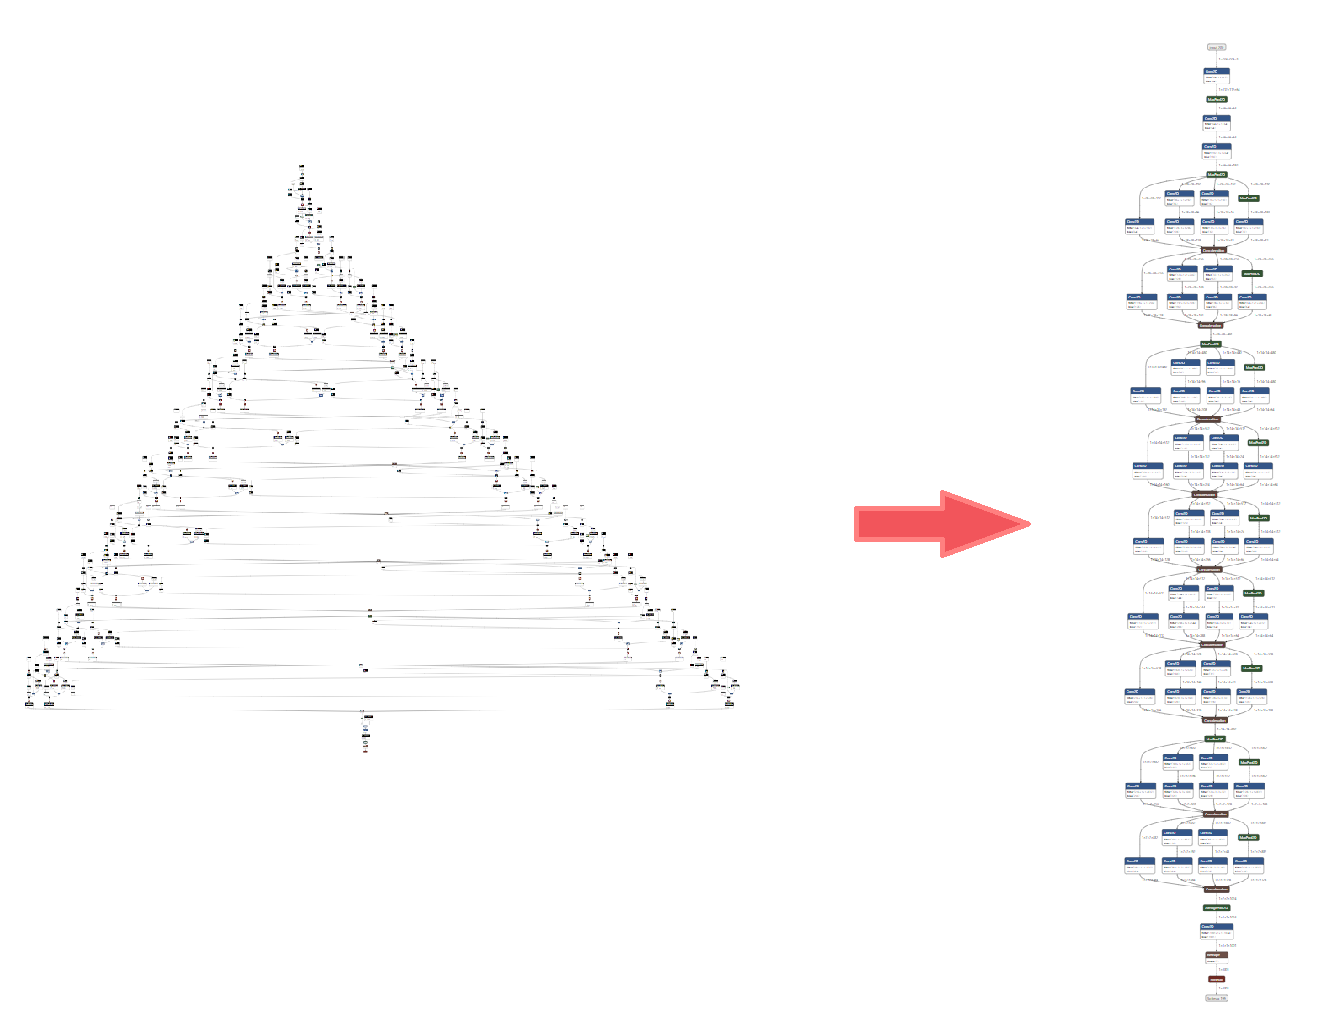

**웹 페이지에서 모델 실행하기**

-추천하는 책
1. 클라우드, 모바일 및 에지 기반의 딥러닝 실용가이드
2. 구글 브레인팀에게 배우는딥러닝 with Tensorflow.js